In [64]:
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

def load_pro_mat_to_dataframe(file_path):
    """
    Load downsampled fields from a MATLAB v7.3 _pro.mat file into a pandas DataFrame.

    Parameters:
        file_path (str): Path to the _pro.mat file.

    Returns:
        pd.DataFrame: A DataFrame containing the downsampled fields.
    """
    # Open the HDF5 file
    with h5py.File(file_path, 'r') as f:
        # Navigate to the 'exptData' group
        if 'exptData' not in f:
            raise ValueError(f"The file {file_path} does not contain 'exptData'.")
        
        expt_data = f['exptData']
        
        # List of fields to extract
        fields_to_include = [
            'tDS', 'optoStim', 'g4displayXPos','headingPosition', 'angularVelocity',
            'angularSpeed', 'forwardPosition', 'forwardVelocity',
            'sidewaysPosition', 'sidewaysVelocity', 'totSpeed', 'x', 'y'
        ]
        
        # Extract and flatten the fields
        data_dict = {}
        for field in fields_to_include:
            if field in expt_data:
                data_dict[field] = expt_data[field][()].flatten()
            else:
                raise KeyError(f"Field '{field}' is missing in 'exptData'.")
        data_dict['angularSpeed_radian'] = np.radians(data_dict['angularSpeed'])
    # Create DataFrame
    df = pd.DataFrame(data_dict)
    return df

# Example usage:
# file_path = 'path/to/your/_pro.mat'
# df = load_pro_mat_to_dataframe(file_path)
# print(df)


def smooth_time_series(df, column, window_size, method='moving_average'):
    """
    Smooth a time series in a Pandas DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the time series.
        column (str): The column name of the time series to be smoothed.
        window_size (int): The size of the smoothing window.
        method (str): The smoothing method ('moving_average' or 'gaussian').

    Returns:
        pd.Series: A smoothed version of the time series.
    """
    if column not in df.columns:
        raise KeyError(f"Column '{column}' not found in DataFrame.")
    
    if method == 'moving_average':
        # Moving average smoothing
        smoothed_series = df[column].rolling(window=window_size, center=True).mean()
    elif method == 'gaussian':
        # Gaussian smoothing
        smoothed_series = df[column].rolling(window=window_size, win_type='gaussian', center=True).mean(std=window_size / 2)
    else:
        raise ValueError("Method must be 'moving_average' or 'gaussian'.")
    
    return smoothed_series




def plot_opto_window_overlay(df, forward_velocity_col='forwardVelocity', angular_speed_col='angularSpeed_radian', opto_col='optoStim', time_col='tDS', window=(-2, 3)):
    """
    Overlay forward velocity and angular speed traces around multiple opto-stim onset windows.
    Also plots the average trace with a thicker line.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        forward_velocity_col (str): Column name for forward velocity.
        angular_speed_col (str): Column name for angular speed.
        opto_col (str): Column name for opto stimulation indicator.
        time_col (str): Column name for the time vector.
        window (tuple): Time window around opto-stim onset in seconds (start, end).

    Returns:
        None
    """
    if opto_col not in df.columns or time_col not in df.columns:
        raise KeyError(f"Columns '{opto_col}' and/or '{time_col}' are missing in the DataFrame.")

    # Detect opto-stim onset times (transition from <0.1 to >0.1)
    opto_onset_indices = df.index[(df[opto_col].shift(1, fill_value=0) < 0.1) & (df[opto_col] > 0.1)]
    opto_on_times = df.loc[opto_onset_indices, time_col].values

    if len(opto_on_times) == 0:
        raise ValueError("No opto-stim 'onset' events found in the data.")

    aligned_traces = {'time': [], 'forward_velocity': [], 'angular_speed': []}

    # Loop through each opto-stim onset time and extract the surrounding window
    for opto_time in opto_on_times:
        df['aligned_time'] = df[time_col] - opto_time
        window_mask = (df['aligned_time'] >= window[0]) & (df['aligned_time'] <= window[1])
        window_df = df[window_mask]

        if not window_df.empty:
            aligned_traces['time'].append(window_df['aligned_time'].values)
            aligned_traces['forward_velocity'].append(window_df[forward_velocity_col].values)
            aligned_traces['angular_speed'].append(window_df[angular_speed_col].values)

    # Convert aligned traces to arrays for averaging
    forward_velocity_array = np.array(aligned_traces['forward_velocity'])
    angular_speed_array = np.array(aligned_traces['angular_speed'])

    # Calculate the average trace
    avg_forward_velocity = np.nanmean(forward_velocity_array, axis=0)
    avg_angular_speed = np.nanmean(angular_speed_array, axis=0)

    # Plotting
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot forward velocity
    for trace in aligned_traces['forward_velocity']:
        ax[0].plot(aligned_traces['time'][0], trace, color='blue',alpha=0.3)
    ax[0].plot(aligned_traces['time'][0], avg_forward_velocity, color='blue', linewidth=2, label='Average Trace')
    ax[0].axvline(0, color='red', linestyle='--', label='Opto-Stim Onset')
    ax[0].set_ylabel('Forward Velocity (units)')
    ax[0].set_title('Forward Velocity Around Opto-Stim Onset')
    ax[0].legend()

    # Plot angular speed
    for trace in aligned_traces['angular_speed']:
        ax[1].plot(aligned_traces['time'][0], trace, color='green', alpha=0.3)
    ax[1].plot(aligned_traces['time'][0], avg_angular_speed, color='green', linewidth=2, label='Average Trace')
    ax[1].axvline(0, color='red', linestyle='--', label='Opto-Stim Onset')
    ax[1].set_xlabel('Time (s)')
    ax[1].set_ylabel('Angular Speed (units)')
    ax[1].set_title('Angular Speed Around Opto-Stim Onset')
    ax[1].legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage:
# df is your DataFrame containing the required columns
# plot_opto_window_overlay(df)


In [55]:
# Example usage:
file_path = '//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/opto_behavior/summary_MBON09/_2024_12_06_fly01_session01_trial01B pattern20 stim2 ftmode0_pro.mat'
df = load_pro_mat_to_dataframe(file_path)
df

,tDS,optoStim,g4displayXPos,headingPosition,angularVelocity,angularSpeed,forwardPosition,forwardVelocity,sidewaysPosition,sidewaysVelocity,totSpeed,x,y,angularSpeed_radian
0,0.0000,0.0,6.150311,10.167017,-15.725880,15.725880,0.001947,-0.186355,-0.005570,-0.785928,2.207391,0.000000,0.000000,0.274468
1,0.0015,0.0,6.150918,10.143315,-15.783733,15.783733,0.001631,-0.180952,-0.006781,-0.783202,2.203805,-0.001175,-0.000272,0.275478
2,0.0030,0.0,6.151526,10.119364,-15.837127,15.837127,0.001325,-0.175379,-0.007991,-0.780234,2.199459,-0.002345,-0.000536,0.276410
3,0.0045,0.0,6.150716,10.095173,-15.885580,15.885580,0.001027,-0.169634,-0.009200,-0.777013,2.194297,-0.003510,-0.000792,0.277256
4,0.0060,0.0,6.150716,10.070752,-15.928585,15.928585,0.000739,-0.163712,-0.010407,-0.773524,2.188264,-0.004670,-0.001039,0.278006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266662,399.9930,0.0,5.692596,127.549205,18.834528,18.834528,767.189817,1.393224,-336.858621,-0.515737,3.388222,336.665258,396.155649,0.328725
266663,399.9945,0.0,5.693001,127.575903,18.474794,18.474794,767.191749,1.361897,-336.859047,-0.477407,3.290311,336.667402,396.155344,0.322446
266664,399.9960,0.0,5.692798,127.601844,18.118488,18.118488,767.193619,1.331057,-336.859426,-0.440757,3.194837,336.669478,396.155011,0.316227
266665,399.9975,0.0,5.692596,127.627028,17.765929,17.765929,767.195427,1.300716,-336.859759,-0.405729,3.101778,336.671490,396.154651,0.310074


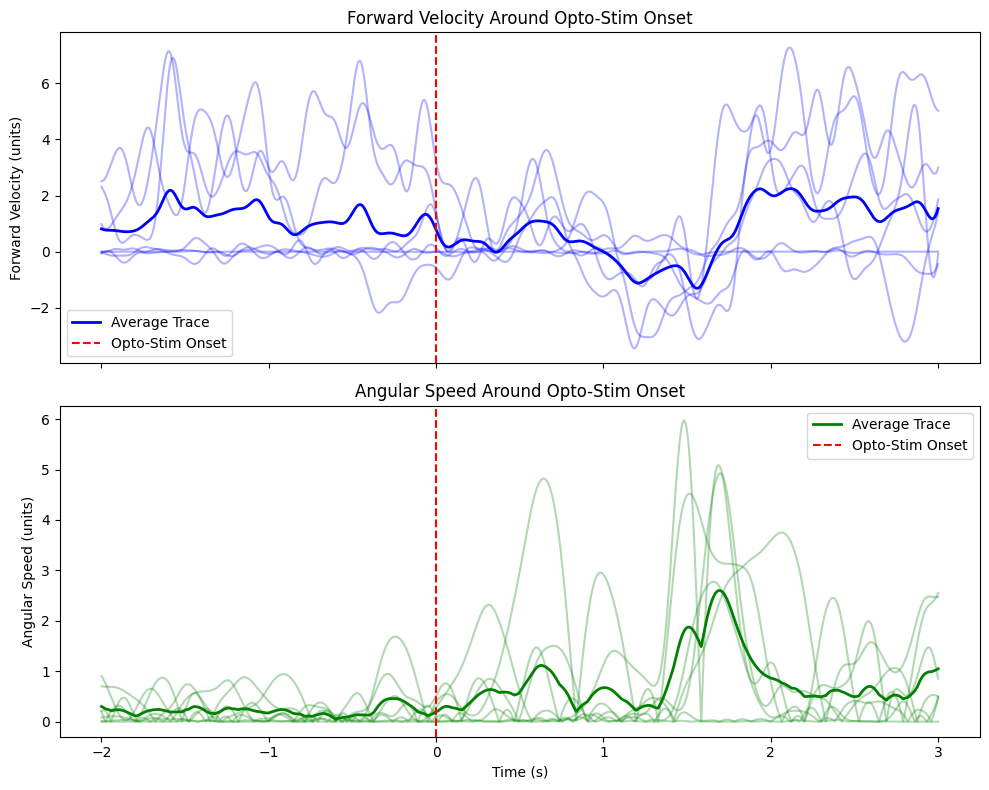

In [65]:
plot_opto_window_overlay(df)